[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Arch_2D.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [ ]:
'''        for tag, xyz, value in zip(self.nodeparameters_tags, self.nodeparameters_xyzs, self.nodeparameters_values):
            if xyz == 0:
                self.model.nodes[tag].X = value
            elif xyz == 1:
                self.model.nodes[tag].Y = value
            elif xyz == 2:
                self.model.nodes[tag].Z = value'''

In [8]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define the objective function and the gradient of the objective

*   The geometry, mesh
*   Build the SSO model


Setup: the nodes, connectivity, the load, the element's properties

In [9]:
#Nodes
n_node = 51
x_span = 30
x_nodes = np.linspace(0,x_span,n_node)
y_nodes = np.zeros(n_node)
z_nodes = np.random.uniform(0,0.5,n_node)
z_nodes[0] = 0
z_nodes[n_node-1] = 0
design_nodes = np.array([i for i in range(n_node) if i!=0 and i!=n_node-1])
design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))
non_design_nodes = np.array([i for i in range(n_node) if i==0 or i==n_node-1])
#Connectivity
#Connectivity
n_ele = n_node -1 #number of elements
cnct = np.zeros((n_ele,2),dtype=int) #connectivity matrix
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
    cnct[i,0] = i
    cnct[i,1] = i+1
    x_ele[i,:] = [x_nodes[i],x_nodes[i+1]]
    y_ele[i,:] = [y_nodes[i],y_nodes[i+1]]
    z_ele[i,:] = [z_nodes[i],z_nodes[i+1]]

#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900#Young's modulus (Gpa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area

Q = 1 #Nodal load magnitude


Draw the initial geometry

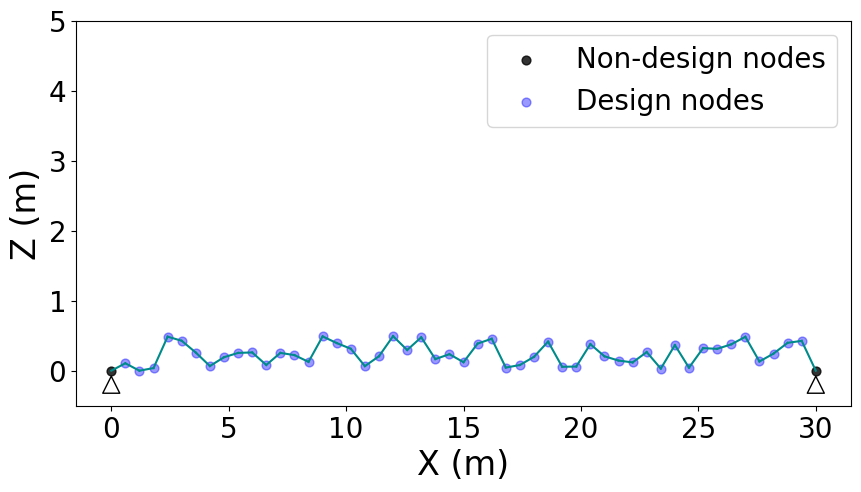

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.tick_params(labelsize=20)
ax.set_ylim(-0.5,5)
ax.set_xlabel('X (m)',fontsize=24)
ax.set_ylabel('Z (m)',fontsize=24)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',alpha=0.8,label='Non-design nodes',s=40)
plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2, s=150, facecolors='none', edgecolors='black',marker='^')
ax.scatter(x_nodes[design_nodes],z_nodes[design_nodes],color='blue',alpha=0.4,label='Design nodes',s=40)

plt.legend(fontsize=20, loc='best')
plt.show()

# Create the initial model

In [11]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 

# Create the optimization model based on intiial FEA model

In [12]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()

In [13]:
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [ ]:
%timeit sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)

In [8]:
def objective(x,sso_model=sso_model):
    sso_model.update_nodeparameter(x) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    return C,sens #sens_params

In [9]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(100) #max iteration
opt.set_step_size(5e-2) #step size
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 941.3875211439141
Step 1, objective = 6096.295635396225
Step 2, objective = 2897.8271950874027
Step 3, objective = 490.77187020492784
Step 4, objective = 103.40754242541611
Step 5, objective = 63.76628681761325
Step 6, objective = 44.11308762847938
Step 7, objective = 32.022621714700264
Step 8, objective = 23.984263109169007
Step 9, objective = 18.388691680555606
Step 10, objective = 14.36597781314713
Step 11, objective = 11.405247001920845
Step 12, objective = 9.187370421579693
Step 13, objective = 7.503076290737381
Step 14, objective = 6.209881604990182
Step 15, objective = 5.207922099554457
Step 16, objective = 4.425598808992443
Step 17, objective = 3.810643701384425
Step 18, objective = 3.324340042331467
Step 19, objective = 2.937663546363637
Step 20, objective = 2.628637798580967
Step 21, objective = 2.3804819627768605
Step 22, objective = 2.180289494071084
Step 23, objective = 2.0180709933077163
Step 24, objective = 1.886051739549928
Step 25, objective = 1.778

# Draw the final structure

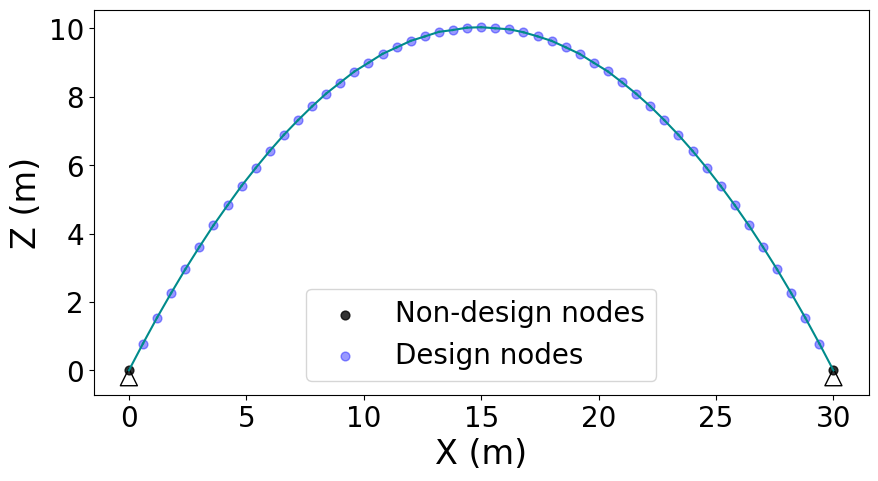

In [10]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.tick_params(labelsize=20)
#ax.set_ylim(-0.5,5)
ax.set_xlabel('X (m)',fontsize=24)
ax.set_ylabel('Z (m)',fontsize=24)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',alpha=0.8,label='Non-design nodes',s=40)
plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2, s=150, facecolors='none', edgecolors='black',marker='^')
ax.scatter(x_nodes[design_nodes],z_nodes[design_nodes],color='blue',alpha=0.4,label='Design nodes',s=40)

plt.legend(fontsize=20, loc='best')
plt.show()